# Credit Card Fraud Detection Project

## Introduction

This notebook explores credit card transaction data to detect fraudulent activities using machine learning models. Due to the significant class imbalance (fraud cases are much rarer than legitimate transactions), specialized resampling techniques and model evaluation metrics are required.

## Step 1: Importing Libraries & Data

In [1]:
%pip install xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    HalvingGridSearchCV
)
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report
)
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import joblib

import warnings
warnings.filterwarnings('ignore')

N_JOBS = -1

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Shape:", df.shape)
print("Null values per column:\n", df.isnull().sum())

Shape: (284807, 31)
Null values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
print(df.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [5]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [6]:
class_counts = df['Class'].value_counts()
print(class_counts)
print("Percentage of fraud cases: {:.4f}%".format(100 * class_counts[1] / class_counts.sum()))

Class
0    284315
1       492
Name: count, dtype: int64
Percentage of fraud cases: 0.1727%


The dataset consists of 284,807 transactions, where only 0.172% of them are fraudulent. This confirms the severe class imbalance in the dataset.

## Step 2: Exploratory Data Analysis (EDA)

- Fraud vs. Non-Fraud Distribution:

  - The dataset contains 99.83% legitimate transactions and 0.17% fraudulent transactions.


- Feature distributions are analyzed to identify significant differences between fraud and non-fraud cases.

- Correlation heatmaps and feature importance are examined to detect relationships.

Visualize the Transaction Amount distribution per Class

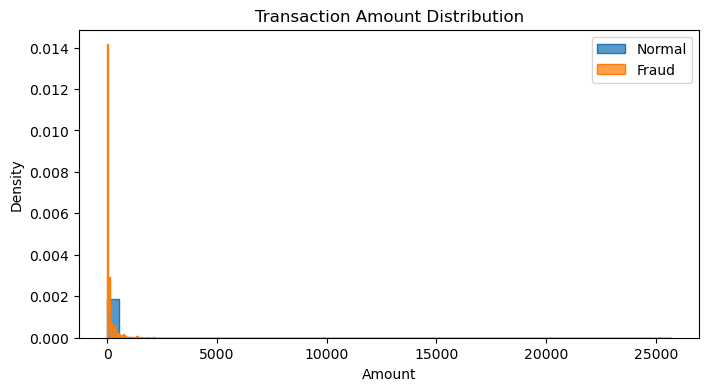

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df[df['Class']==0]['Amount'], bins=50, label='Normal', stat='density', element='step')
sns.histplot(df[df['Class']==1]['Amount'], bins=50, label='Fraud', stat='density', element='step')
plt.title('Transaction Amount Distribution')
plt.legend()
plt.show()

The distributions are approximately the same, although unable to see the distibution for larger values.

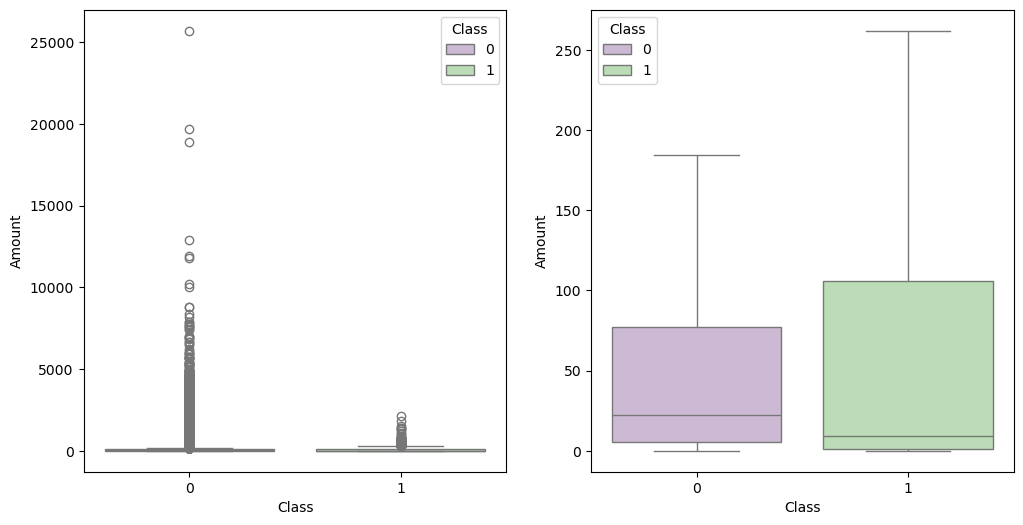

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

Show amount quantiles per class

In [9]:
display(df.Amount[df.Class==1].describe().T)

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
display(df.Amount[df.Class==0].describe().T)

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's do a Hypthesis test for the mean amount difference using monte carlo simulation.

Null-Hypothesis : There isn't a difference between the mean transaction amounts for the fraudulent and non-fraudulent cases.
Alternative-Hypothesis : The mean transaction amount of the fraudulent class is higher than the mean transaction amount of the non-fraudulent class.

Significance Level of 5%.

Observed mean difference: 33.9203
One-sided p-value: 0.0094


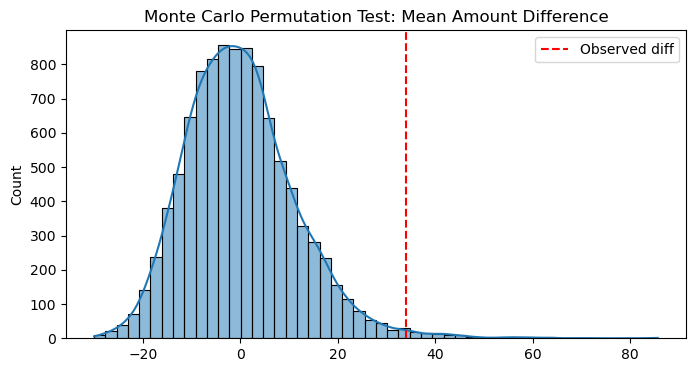

In [11]:
amount_fraud = df.loc[df['Class']==1,'Amount'].values
amount_normal = df.loc[df['Class']==0,'Amount'].values
obs_diff = amount_fraud.mean() - amount_normal.mean()
n_simulations = 10000
diffs =np.empty(n_simulations)
combined = np.concatenate([amount_fraud,amount_normal])
n_fraud = amount_fraud.size
for i in range(n_simulations):
    np.random.shuffle(combined)
    perm_fraud = combined[:n_fraud]
    perm_normal = combined[n_fraud:]
    diffs[i] = perm_fraud.mean() - perm_normal.mean()
p_value = np.mean(diffs >= obs_diff)
print(f"Observed mean difference: {obs_diff:.4f}")
print(f"One-sided p-value: {p_value:.4f}")
plt.figure(figsize=(8,4))
sns.histplot(diffs, bins=50, kde=True)
plt.axvline(obs_diff, color='red', linestyle='--', label='Observed diff')
plt.title('Monte Carlo Permutation Test: Mean Amount Difference')
plt.legend()
plt.show()


With a p-value of 0.0094 < 0.05, we have enough evidence to conclude that the true mean transaction amount of the fradulent class is higher than the true mean transaction amount of the non-fraudulent class for this data.

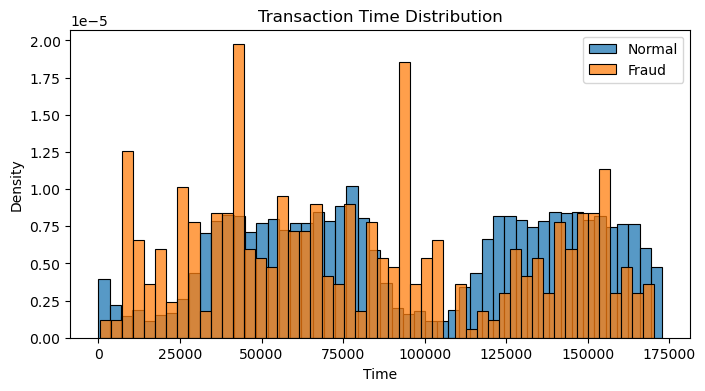

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df[df['Class']==0]['Time'], bins=50, label='Normal', stat='density')
sns.histplot(df[df['Class']==1]['Time'], bins=50, label='Fraud', stat='density')
plt.title('Transaction Time Distribution')
plt.legend()
plt.show()

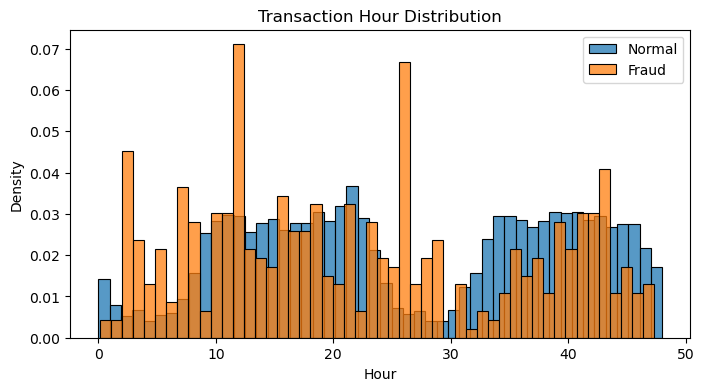

In [13]:
df['Hour'] = df['Time']/3600
plt.figure(figsize=(8,4))
sns.histplot(df[df['Class']==0]['Hour'], bins=50, label='Normal', stat='density')
sns.histplot(df[df['Class']==1]['Hour'], bins=50, label='Fraud', stat='density')
plt.title('Transaction Hour Distribution')
plt.legend()
plt.show()

We can see that most of the fraudulent transactions happen in the 3-12 hour marks of the data as well as between 23-29 hour marks of the data.

Let's add some extra features to see if they have any relationships with other variables

In [14]:
df['Amount_log'] = np.log1p(df['Amount'])
df['Amt_x_Hour'] = df['Amount'] * df['Hour']

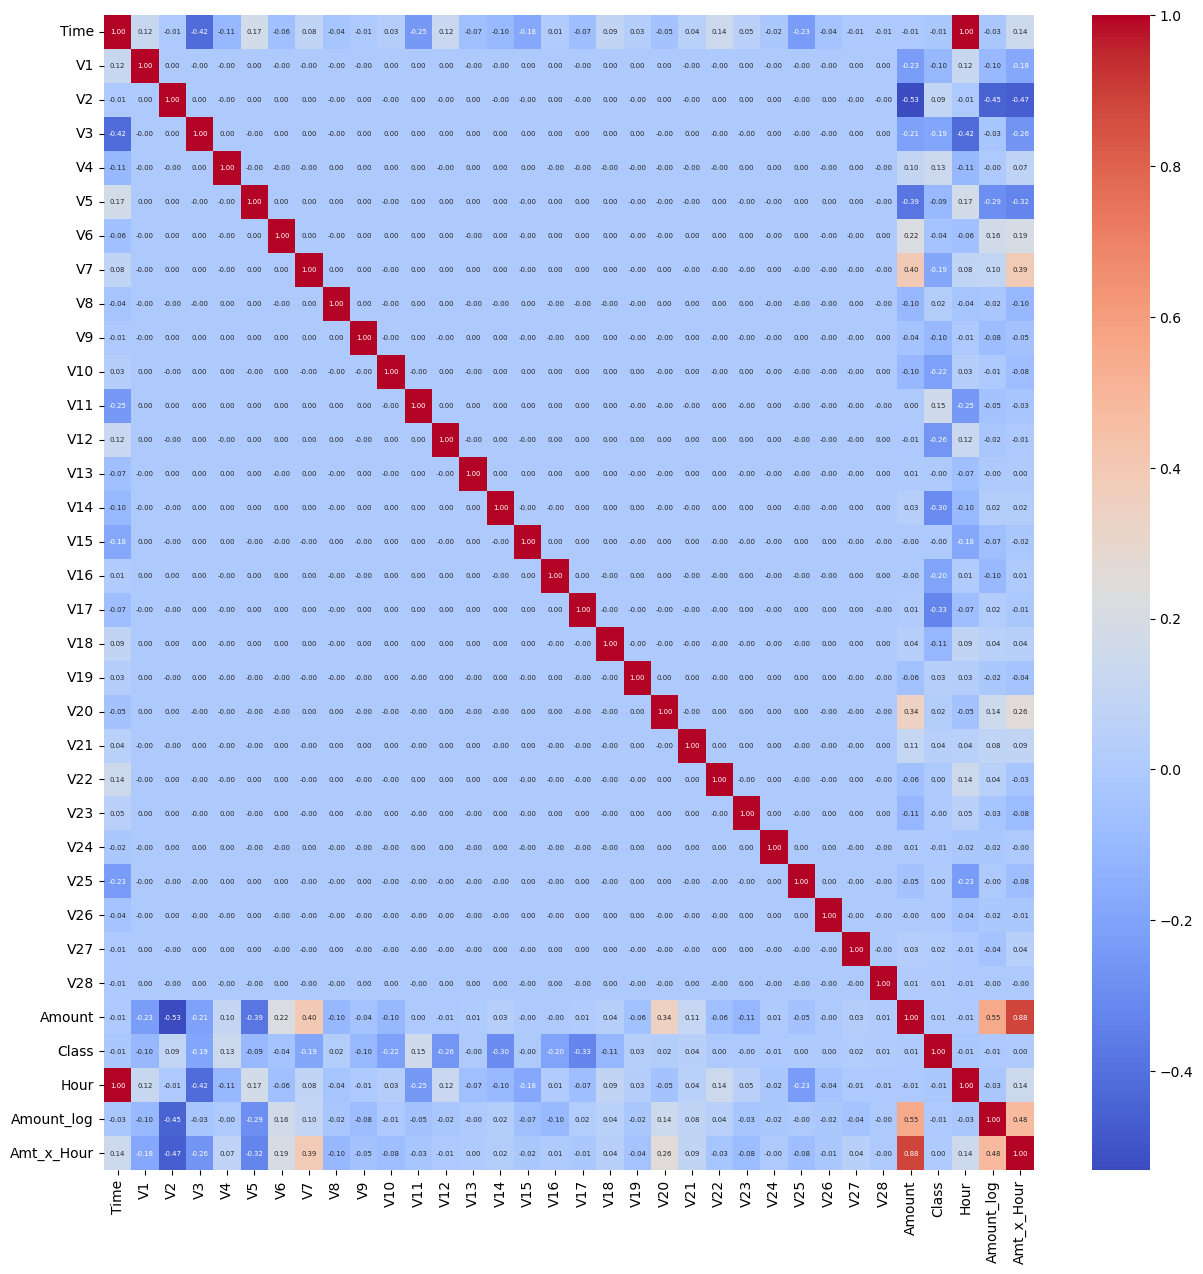

In [15]:
corr = df[df.select_dtypes(include=[np.int64,np.float64]).columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap = 'coolwarm', annot= True,annot_kws={"size":5},fmt='.2f');
plt.show()

We can see that Class has a moderate negative correlation with V17, V14, and V12. It also have a weak positive correlation with V11, Nothing that is worth mentioning though. In addition, the engineered features don't have an effect on the class variable

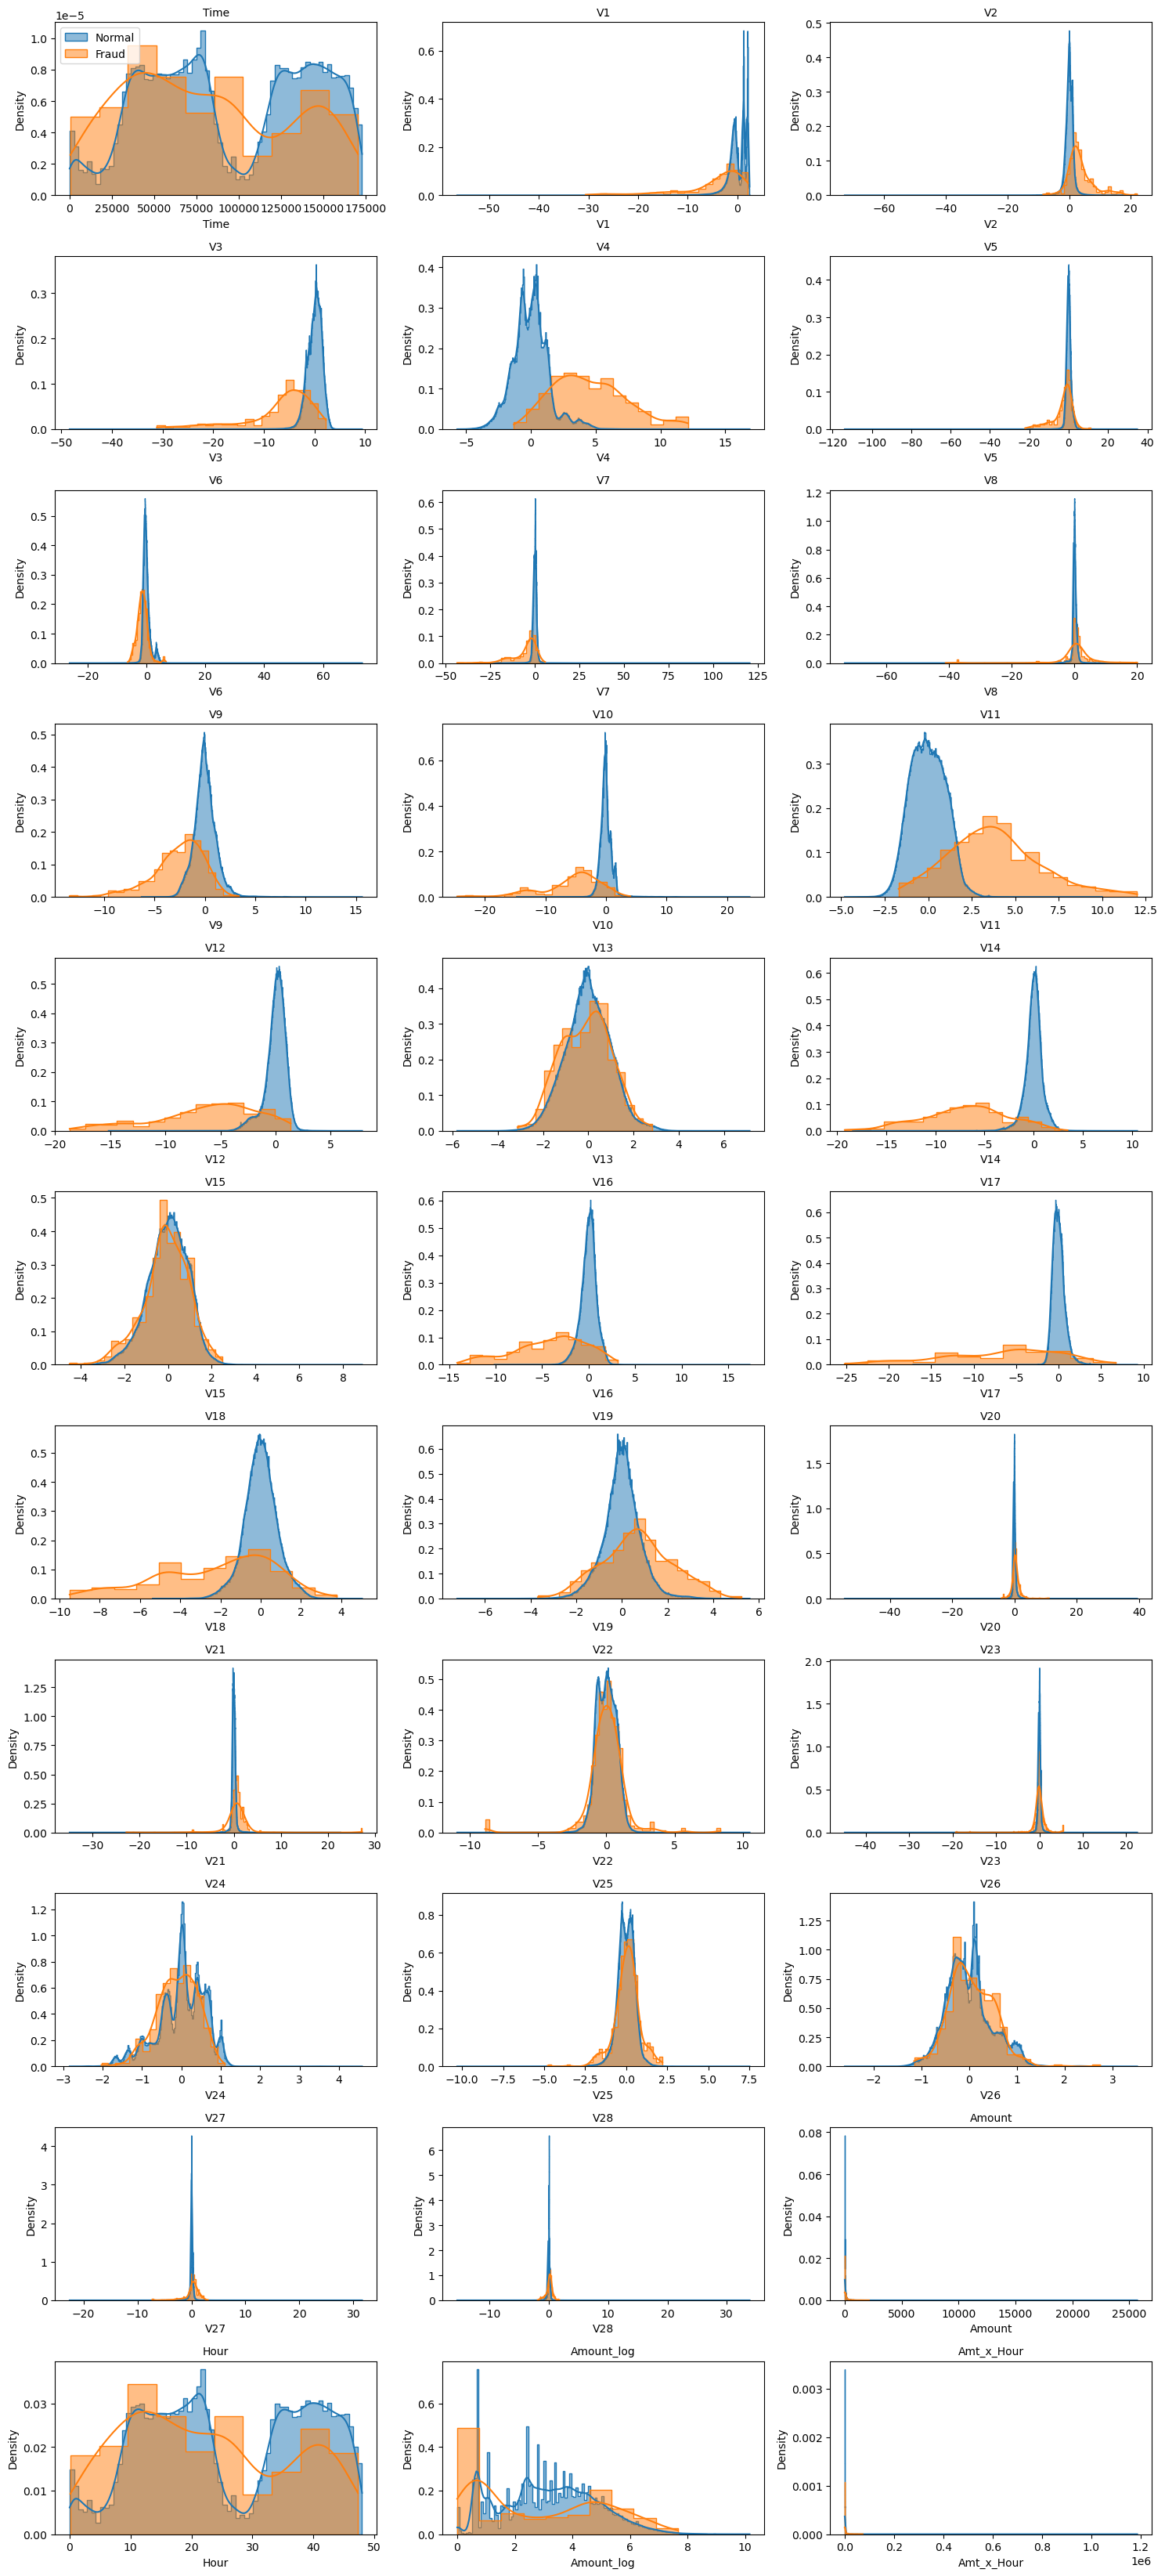

In [16]:
df_cols = df.drop('Class', axis=1).columns
n_features = len(df_cols)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(n_cols*5, n_rows*3))
for i, col in enumerate(df_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df.loc[df['Class']==0, col], kde=True, stat='density', element='step', label='Normal')
    sns.histplot(df.loc[df['Class']==1, col], kde=True, stat='density', element='step', label='Fraud')
    plt.title(col, fontsize=10)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

We can see that the prior mentioned variables who somewhat had a moderate-weak correlation with the Class variable, 17,14,12,11, happen to have the same type of pattern of distibutions between the fraudulent and non-fraudulent classes. Where the distribution of the fraudulent class is much flatter and its density is not concentrated around any value. However, for the non-fraudulent class the distibution is very skinny and is concentrated around 0. It's safe to mention that V18, V16, and V4 experience the same pattern. Also, the new feature Amount_log has distinct distributions for both of the classes. We will see later how much of a role each of those variables play in the models.

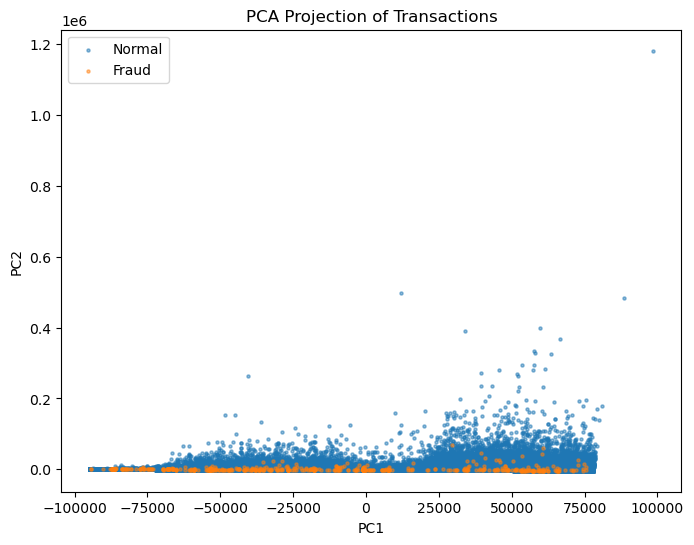

In [17]:
features = df.drop('Class', axis=1)
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(features)
plt.figure(figsize=(8,6))
plt.scatter(pcs[df['Class']==0,0], pcs[df['Class']==0,1], s=5, label='Normal', alpha=0.5)
plt.scatter(pcs[df['Class']==1,0], pcs[df['Class']==1,1], s=5, label='Fraud', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of Transactions')
plt.legend()
plt.show()

In [18]:
print(pca.explained_variance_ratio_)

[0.9763213  0.02367331]


1.	Almost all the information is in PC1. The first component alone explains nearly all the variation in your transactions—so if you projected the data onto just that one axis, you’d lose very little.

2.	PC2 adds a tiny orthogonal “twist.” The second component captures the remaining ~2.4% of variance in a direction uncorrelated with PC1. It may help with finer separation, but it’s a much weaker signal.

3.	Dimensionality reduction is extremely effective. Since PC1 already carries ~97.6% of the variance, you could (for many purposes) reduce 30 features to a single component and still retain almost all of the dataset’s structural information.

## Step 3: Data Preprocessing & Splitting

- Features are standardized using StandardScaler to normalize distributions.

- The dataset is split into training and testing sets using train_test_split.

- Handling of missing values and outliers is performed if necessary.

In [21]:
df['Amount'] = RobustScaler().fit_transform(df['Amount'].to_numpy().reshape(-1, 1))
df['Amount_log'] = RobustScaler().fit_transform(df['Amount_log'].to_numpy().reshape(-1, 1))
df['Amt_x_Hour'] = RobustScaler().fit_transform(df['Amt_x_Hour'].to_numpy().reshape(-1, 1))

time = df['Time']
df['Time'] = (time - time.min()) / (time.max() - time.min())

hour = df['Hour']
df['Hour'] = (hour - hour.min()) / (hour.max() - hour.min())

In [22]:
X = df.drop('Class',axis=1)
y = df.Class

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=1
)

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 33), (227845,), (56962, 33), (56962,))

## Step 4: Model Building

In [27]:
cv = StratifiedKFold(n_splits=min(5, int(y_train.sum())), shuffle=True, random_state=1)
scoring = 'average_precision'

memory = joblib.Memory(location="~/sklearn_cache",verbose=0)

In [30]:
# Grid search
param_grid_log = {
    'penalty': ['l1','l2'],
    'C': np.logspace(-4, 4, 10)
}
grid_log = HalvingGridSearchCV(
    LogisticRegression(
        solver='saga',
        max_iter=10000,
        class_weight='balanced',
        random_state=1
    ),
    param_grid_log,
    scoring=scoring,
    cv=cv,
    n_jobs=N_JOBS
)
grid_log.fit(X_train, y_train)

# Metrics
cv_log = grid_log.best_score_
test_pred = grid_log.predict_proba(X_test)[:,1]
test_log = average_precision_score(y_test, test_pred)
y_pred = grid_log.predict(X_test)
# Report
results_log_none = pd.DataFrame([{  
    'Model':'Logistic',
    'Resampling':'None',
    'CV PR-AUC':cv_log,
    'Test PR-AUC':test_log,
    'Best Params':grid_log.best_params_
}])
print("Classification Report (Logistic None):")
print(classification_report(y_test, y_pred))
display(results_log_none)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Classification Report (Logistic None):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,Logistic,None,0.730044,0.81931,"{'C': 0.3593813663804626, 'penalty': 'l1'}"


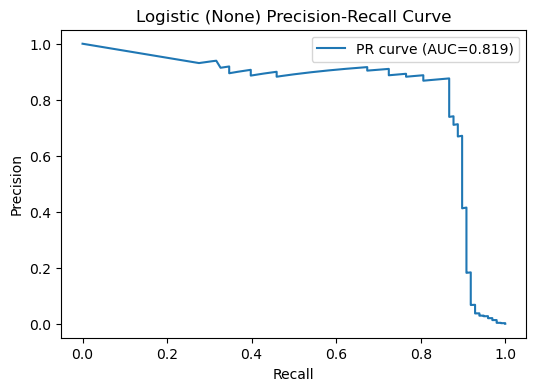

In [31]:
precision, recall, _ = precision_recall_curve(y_test, test_pred)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_log:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic (None) Precision-Recall Curve')
plt.legend()
plt.show()

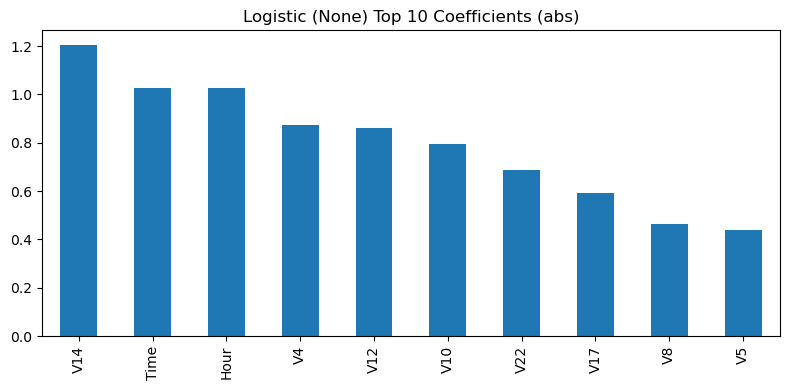

In [34]:
coef_none = pd.Series(
    grid_log.best_estimator_.coef_[0],
    index=X_train.columns
).abs().sort_values(ascending=False)
plt.figure(figsize=(8,4))
coef_none.head(10).plot(kind='bar')
plt.title('Logistic (None) Top 10 Coefficients (abs)')
plt.tight_layout()
plt.show()

We can see that V4 and V14, which have been mentioned earlier as variables that might have an effect on the model's decision, play a larger role in the Logistic Regression model than other varaibles.

In [37]:
grid_log_us = HalvingGridSearchCV(
    ImbPipeline([('RandomUnderSampler', RandomUnderSampler(random_state=1)), ('clf', LogisticRegression(solver='saga', max_iter=10000, random_state=1))],memory=memory),
    {'clf__penalty':['l1','l2'], 'clf__C':np.logspace(-4,4,20)},
    scoring=scoring, cv=cv, n_jobs=N_JOBS
)
grid_log_us.fit(X_train, y_train)
cv_log_us = grid_log_us.best_score_
test_pred_us = grid_log_us.predict_proba(X_test)[:,1]
test_log_us = average_precision_score(y_test, test_pred_us)
results_log_us = pd.DataFrame([{ 'Model':'Logistic', 'Resampling':'RandomUnderSampler', 'CV PR-AUC':cv_log_us, 'Test PR-AUC':test_log_us, 'Best Params':grid_log_us.best_params_ }])
display(results_log_us)

,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,Logistic,RandomUnderSampler,0.660371,0.675916,"{'clf__C': 0.0001, 'clf__penalty': 'l2'}"


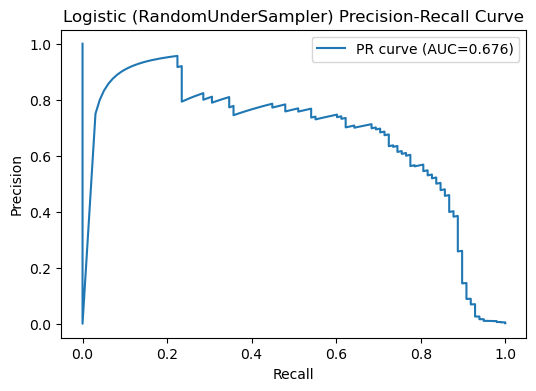

In [38]:
precision, recall, _ = precision_recall_curve(y_test, test_pred_us)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_log_us:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic (RandomUnderSampler) Precision-Recall Curve')
plt.legend()
plt.show()

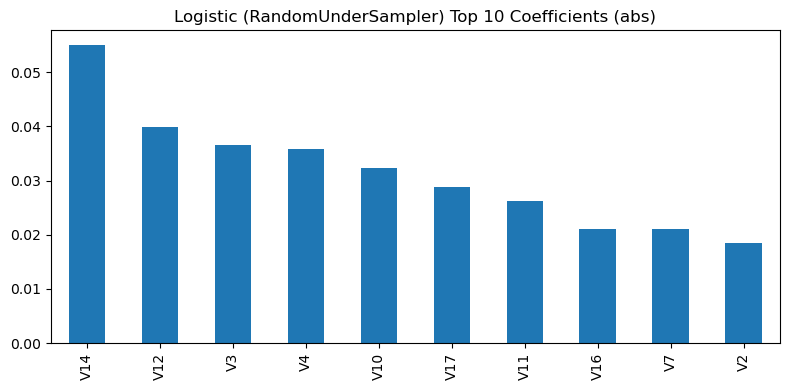

In [39]:
coef_us = pd.Series(
    grid_log_us.best_estimator_.named_steps['clf'].coef_[0],
    index=X_train.columns
).abs().sort_values(ascending=False)
plt.figure(figsize=(8,4))
coef_us.head(10).plot(kind='bar')
plt.title('Logistic (RandomUnderSampler) Top 10 Coefficients (abs)')
plt.tight_layout()
plt.show()

With RandomUnderSampler resampling, the features' coefficients have been amplified and seem to have larger absolute values than the same coefficients for the non-RandomUnderSampler Log Reg model. In addition, V1 seems to have transormed to be one of the features that play the largest roles in the model's predictions.

In [40]:
# Grid search
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth':    [None, 2,10],
    'min_samples_split':[2,5,10],
    'max_features':['sqrt','log2']
}
grid_rf = HalvingGridSearchCV(
    RandomForestClassifier(
        criterion='gini',
        class_weight='balanced',
        random_state=1
    ),
    param_grid_rf,
    scoring=scoring,
    cv=cv,
    n_jobs=N_JOBS
)
grid_rf.fit(X_train, y_train)
# Metrics
cv_rf = grid_rf.best_score_
test_pred_rf = grid_rf.predict_proba(X_test)[:,1]
test_rf = average_precision_score(y_test, test_pred_rf)
y_pred_rf = grid_rf.predict(X_test)
print("Classification Report (RandomForest None):")
print(classification_report(y_test, y_pred_rf))
# Results table
results_rf_none = pd.DataFrame([{ 'Model':'RandomForest','Resampling':'None','CV PR-AUC':cv_rf,'Test PR-AUC':test_rf,'Best Params':grid_rf.best_params_ }])
display(results_rf_none)

Classification Report (RandomForest None):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,RandomForest,None,0.843922,0.894526,"{'max_depth': None, 'max_features': 'sqrt', 'm..."


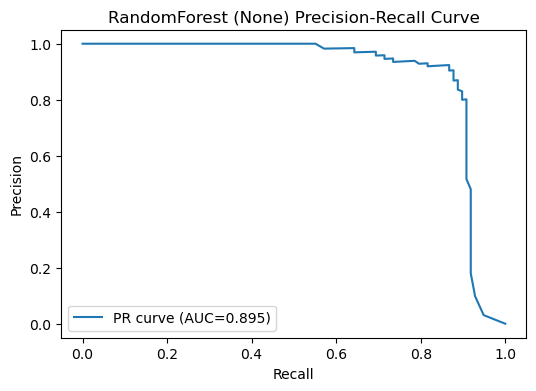

In [41]:
precision, recall, _ = precision_recall_curve(y_test, test_pred_rf)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_rf:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForest (None) Precision-Recall Curve')
plt.legend()
plt.show()

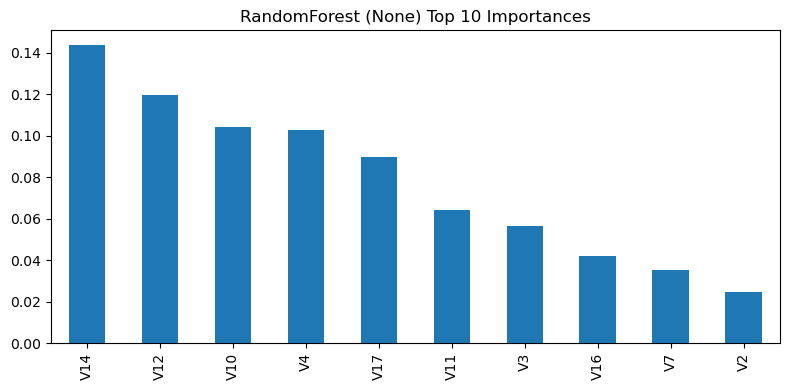

In [43]:
imp_rf_none = pd.Series(
    grid_rf.best_estimator_.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_rf_none.head(10).plot(kind='bar')
plt.title('RandomForest (None) Top 10 Importances')
plt.tight_layout()
plt.show()

In the Random Forest Model, correlation seems to have a larger role in the models prediction criterion as all the variables with the largest absolute correclation coefficients for the Class of the instance (17, 12, 14,11) are in the top 5 most importance features.

In [44]:
# Grid search
grid_rf_us = HalvingGridSearchCV(
    ImbPipeline([('RandomUnderSampler', RandomUnderSampler(random_state=42)), ('clf', RandomForestClassifier(criterion='gini',random_state=1))],memory=memory),
    {'clf__n_estimators':[100,300], 'clf__max_depth':[None,2,10], 'clf__min_samples_split':[2,5,10], 'clf__max_features':['sqrt','log2']},
    scoring=scoring, cv=cv, n_jobs=N_JOBS
)
grid_rf_us.fit(X_train, y_train)
# Metrics
cv_rf_us = grid_rf_us.best_score_
test_pred_rf_us = grid_rf_us.predict_proba(X_test)[:,1]
test_rf_us = average_precision_score(y_test, test_pred_rf_us)
y_pred_rf_us = grid_rf_us.predict(X_test)
print("Classification Report (RandomForest RandomUnderSampler):")
print(classification_report(y_test, y_pred_rf_us))
# Results table
results_rf_us = pd.DataFrame([{ 'Model':'RandomForest','Resampling':'RandomUnderSampler','CV PR-AUC':cv_rf_us,'Test PR-AUC':test_rf_us,'Best Params':grid_rf_us.best_params_ }])
display(results_rf_us)

Classification Report (RandomForest RandomUnderSampler):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.89      0.38        98

    accuracy                           1.00     56962
   macro avg       0.62      0.94      0.69     56962
weighted avg       1.00      1.00      1.00     56962



,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,RandomForest,RandomUnderSampler,0.651681,0.73824,"{'clf__max_depth': 2, 'clf__max_features': 'sq..."


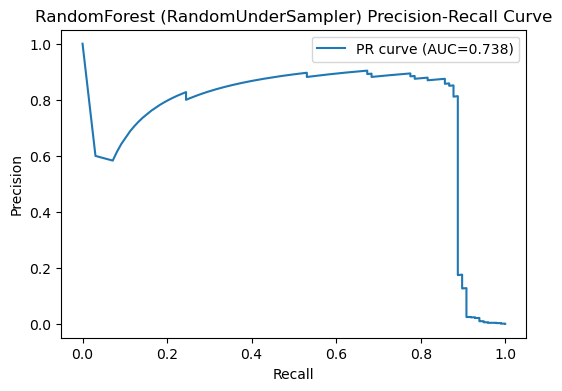

In [45]:
precision, recall, _ = precision_recall_curve(y_test, test_pred_rf_us)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_rf_us:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForest (RandomUnderSampler) Precision-Recall Curve')
plt.legend()
plt.show()

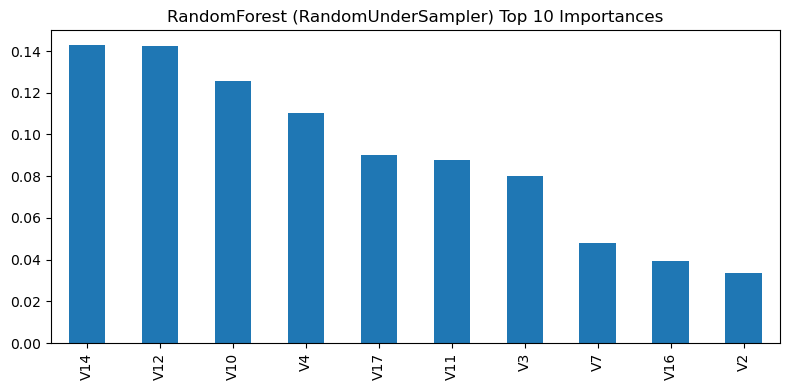

In [46]:
imp_rf_us = pd.Series(
    grid_rf_us.best_estimator_.named_steps['clf'].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_rf_us.head(10).plot(kind='bar')
plt.title('RandomForest (RandomUnderSampler) Top 10 Importances')
plt.tight_layout()
plt.show()

The same case stands here. However, it seems that the PR AUC is higher after the RandomUnderSampler resampling as well as the importance of feature 10.

In [92]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth':    [2,5,7],
    'learning_rate':[0.01,0.1,0.2],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.5,0.9,1.0]
}
grid_xgb = HalvingGridSearchCV(
    XGBClassifier(
        eta=0.039,objective='binary:logistic', eval_metric = 'aucpr',random_state=1
    ),
    param_grid_xgb,
    scoring=scoring,
    cv=cv,
    n_jobs=N_JOBS
)
grid_xgb.fit(X_train, y_train)

cv_xgb = grid_xgb.best_score_
test_pred_xgb = grid_xgb.predict_proba(X_test)[:,1]
test_xgb = average_precision_score(y_test, test_pred_xgb)
y_pred_xgb = grid_xgb.predict(X_test)
print("Classification Report (XGBoost None):")
print(classification_report(y_test, y_pred_xgb))
results_xgb_none = pd.DataFrame([{ 'Model':'XGBoost','Resampling':'None','CV PR-AUC':cv_xgb,'Test PR-AUC':test_xgb,'Best Params':grid_xgb.best_params_ }])
display(results_xgb_none)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: Us

Classification Report (XGBoost None):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.86      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962



,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,XGBoost,None,0.851221,0.90211,"{'colsample_bytree': 0.5, 'learning_rate': 0.1..."


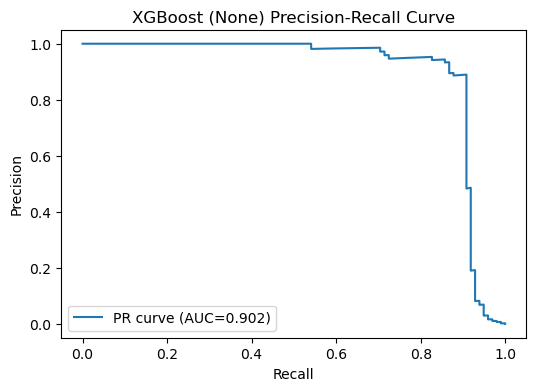

In [93]:
precision, recall, _ = precision_recall_curve(y_test, test_pred_xgb)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_xgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost (None) Precision-Recall Curve')
plt.legend()
plt.show()

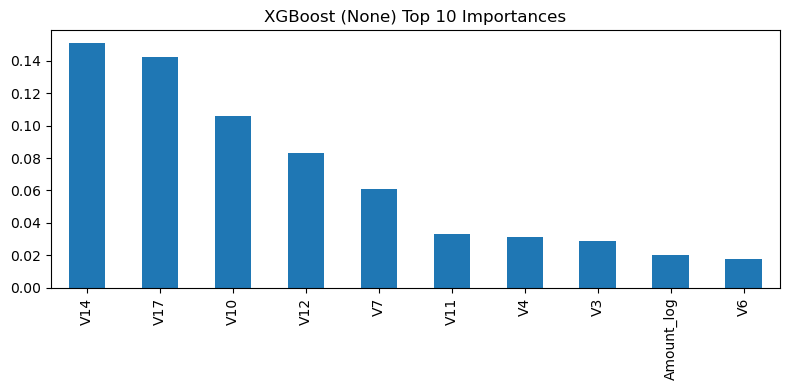

In [94]:
imp_xgb_none = pd.Series(
    grid_xgb.best_estimator_.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_xgb_none.head(10).plot(kind='bar')
plt.title('XGBoost (None) Top 10 Importances')
plt.tight_layout()
plt.show()

XGBoost seems to portray the same case as the Random Forest classifier when it comes to feature importance.

In [95]:
grid_xgb_us = HalvingGridSearchCV(
    ImbPipeline([ ('RandomUnderSampler', RandomUnderSampler(random_state=1)), ('clf', XGBClassifier(eta=0.039,objective='binary:logistic', eval_metric='aucpr', random_state=1))],memory=memory),
    {'clf__n_estimators':[100,200,300], 'clf__max_depth':[3,5,7], 'clf__learning_rate':[0.01,0.1,0.2], 'clf__subsample':[0.6,0.8,1.0], 'clf__colsample_bytree':[0.6,0.8,1.0]},
    scoring=scoring, cv=cv, n_jobs=N_JOBS,error_score=0.0
)
grid_xgb_us.fit(X_train, y_train)
cv_xgb_us = grid_xgb_us.best_score_
test_pred_xgb_us = grid_xgb_us.predict_proba(X_test)[:,1]
test_xgb_us = average_precision_score(y_test, test_pred_xgb_us)
y_pred_xgb_us = grid_xgb_us.predict(X_test)
print("Classification Report (XGBoost RandomUnderSampler):")
print(classification_report(y_test, y_pred_xgb_us))
results_xgb_us = pd.DataFrame([{ 'Model':'XGBoost','Resampling':'RandomUnderSampler','CV PR-AUC':cv_xgb_us,'Test PR-AUC':test_xgb_us,'Best Params':grid_xgb_us.best_params_ }])
display(results_xgb_us)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: Us

Classification Report (XGBoost RandomUnderSampler):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,XGBoost,RandomUnderSampler,0.672988,0.800737,"{'clf__colsample_bytree': 0.6, 'clf__learning_..."


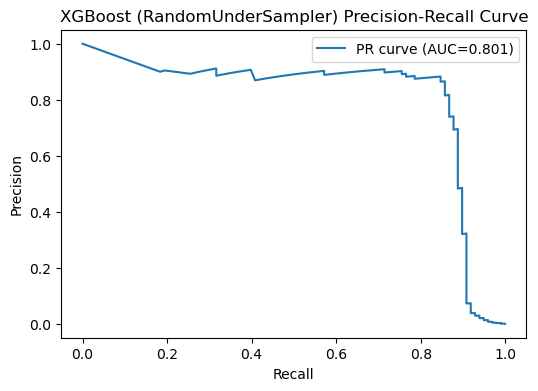

In [96]:
precision, recall, _ = precision_recall_curve(y_test, test_pred_xgb_us)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={test_xgb_us:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost (RandomUnderSampler) Precision-Recall Curve')
plt.legend()
plt.show()

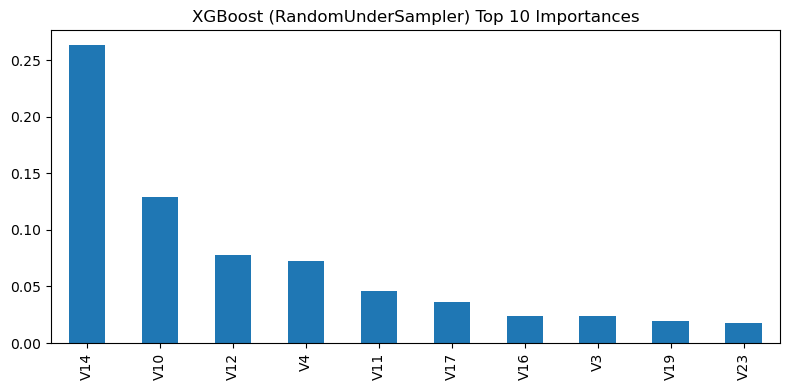

In [97]:
imp_xgb_us = pd.Series(
    grid_xgb_us.best_estimator_.named_steps['clf'].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_xgb_us.head(10).plot(kind='bar')
plt.title('XGBoost (RandomUnderSampler) Top 10 Importances')
plt.tight_layout()
plt.show()

With RandomUnderSampler, we see a major shift in feature importances in the XGBoost Classifier. Feature 14 seems like the only one that plays a role in the model's criterion, with the rest having low importance values. We also see new variables in the bottom 5 of this list.

In [98]:
summary_df = pd.concat([
    results_log_none, results_log_us,
    results_rf_none,   results_rf_us,
    results_xgb_none,  results_xgb_us
], ignore_index=True)
bolded = summary_df.style.set_properties(**{'font-weight':'bold'}, subset=['Model'])
display(bolded)

,Model,Resampling,CV PR-AUC,Test PR-AUC,Best Params
0,Logistic,None,0.730044,0.819310,"{'C': 0.3593813663804626, 'penalty': 'l1'}"
1,Logistic,RandomUnderSampler,0.660371,0.675916,"{'clf__C': 0.0001, 'clf__penalty': 'l2'}"
2,RandomForest,None,0.843922,0.894526,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}"
3,RandomForest,RandomUnderSampler,0.651681,0.738240,"{'clf__max_depth': 2, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 300}"
4,XGBoost,None,0.851221,0.902110,"{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}"
5,XGBoost,RandomUnderSampler,0.672988,0.800737,"{'clf__colsample_bytree': 0.6, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.6}"


So far, the model with the bets Test PR-AUC is the XGBoost Classifier using RandomUnderSampler resampling, with the Random Forest Classifier using RandomUnderSampler being a close second. I now want to shift the perspective and try Neural Networks to see if it can be used as a better classifier.

In [59]:
%pip install keras tensorflow scikeras

Note: you may need to restart the kernel to use updated packages.


In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer,Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

In [61]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
    X_train,y_train,
    test_size=0.25,  # 0.25 * 0.80 = 0.20 of Total
    stratify=y_train,
    random_state=1
)

X_test_nn, y_test_nn = X_test, y_test

In [74]:
def make_nn(x):
    model = Sequential()
    model.add(InputLayer((x.shape[1],)))
    model.add(Dense(2,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[AUC(curve='PR')]
    )
    return model

In [99]:
model_nn = make_nn(X_train_nn)
es = EarlyStopping(patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint('shallow_nn.keras',save_best_only=True)

history_nn = model_nn.fit(
    X_train_nn,y_train_nn,
    validation_data=(X_valid_nn,y_valid_nn),
    epochs = 40,
    batch_size=256,
    callbacks=[es,checkpoint],
    verbose=1
)

#Evaluate on test set
y_prob_nn = model_nn.predict(X_test_nn).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

Epoch 1/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - auc_14: 0.0025 - loss: 0.5819 - val_auc_14: 0.3618 - val_loss: 0.1555
Epoch 2/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - auc_14: 0.0684 - loss: 0.1350 - val_auc_14: 0.6753 - val_loss: 0.0352
Epoch 3/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - auc_14: 0.1283 - loss: 0.0508 - val_auc_14: 0.6976 - val_loss: 0.0143
Epoch 4/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - auc_14: 0.4004 - loss: 0.0308 - val_auc_14: 0.6813 - val_loss: 0.0083
Epoch 5/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - auc_14: 0.4092 - loss: 0.0243 - val_auc_14: 0.6944 - val_loss: 0.0064
Epoch 6/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - auc_14: 0.4410 - loss: 0.0198 - val_auc_14: 0.6799 - val_loss: 0.0056
Epoch 7/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - auc_14: 0.4616 - loss: 0.0167 - val_auc_14: 0.6505 - val_loss: 0.0056
Epoch 8/40
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - auc_14: 0.4748 - loss: 0.0148 - val_auc_14: 0.7008 - val_loss:

Classification Report (Keras None):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.73      0.81        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Test PR-AUC: 0.8193


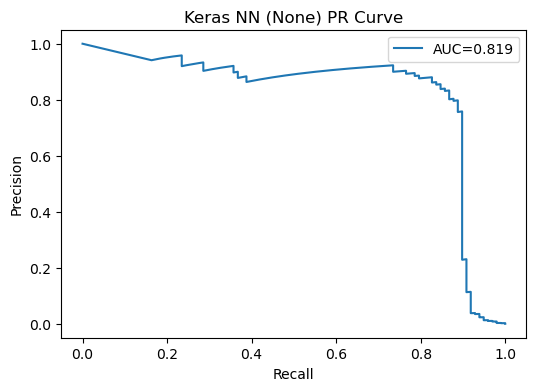

In [100]:
print("Classification Report (Keras None):")
print(classification_report(y_test_nn, y_pred_nn))

test_pr_nn = average_precision_score(y_test_nn, y_prob_nn)
print(f"Test PR-AUC: {test_pr_nn:.4f}")

plt.figure(figsize=(6,4))
prec, rec, _ = precision_recall_curve(y_test_nn, y_prob_nn)
plt.plot(rec, prec, label=f"AUC={test_pr_nn:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Keras NN (None) PR Curve")
plt.legend()
plt.show()

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - auc_15: 0.6711 - loss: 0.6621 - val_auc_15: 0.0155 - val_loss: 0.8663
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc_15: 0.7025 - loss: 0.6375 - val_auc_15: 0.0247 - val_loss: 0.8553
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc_15: 0.7179 - loss: 0.6368 - val_auc_15: 0.0397 - val_loss: 0.8449
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.7725 - loss: 0.6068 - val_auc_15: 0.0596 - val_loss: 0.8346
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.7785 - loss: 0.6033 - val_auc_15: 0.0920 - val_loss: 0.8211
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc_15: 0.8106 - loss: 0.5764 - val_auc_15: 0.1288 - val_loss: 0.8066
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc_15: 0.8039 - loss: 0.5797 - val_auc_15: 0.1541 - val_loss: 0.7938
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc_15: 0.8182 - loss: 0.5795 - val_auc_15: 0.1880 - val_loss: 0.7799
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━

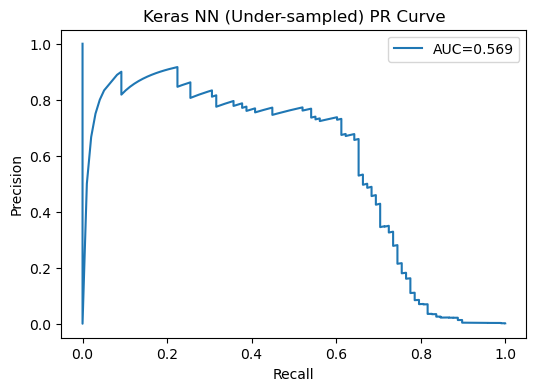

In [101]:
rus = RandomUnderSampler(random_state=1)
X_train_us, y_train_us = rus.fit_resample(X_train_nn, y_train_nn)

model_nn_us = make_nn(X_train_us)
es = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_nn_us.keras', save_best_only=True)

# 4) Fit on the under‐sampled data, validate on your original VALID set
history_nn_us = model_nn_us.fit(
    X_train_us, y_train_us,
    validation_data=(X_valid_nn, y_valid_nn),
    epochs=40,
    batch_size=256,
    callbacks=[es, checkpoint],
    verbose=1
)

# 5) Evaluate on the untouched TEST set
y_prob_nn_us  = model_nn_us.predict(X_test_nn).ravel()
y_pred_nn_us  = (y_prob_nn_us >= 0.5).astype(int)

print("Classification Report (Keras + undersampling):")
print(classification_report(y_test_nn, y_pred_nn_us))

test_pr_nn_us = average_precision_score(y_test_nn, y_prob_nn_us)
print(f"Test PR-AUC: {test_pr_nn_us:.4f}")

plt.figure(figsize=(6,4))
prec, rec, _ = precision_recall_curve(y_test_nn, y_prob_nn_us)
plt.plot(rec, prec, label=f"AUC={test_pr_nn_us:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Keras NN (Under-sampled) PR Curve")
plt.legend()
plt.show()


The model is overfitting. Let's introduce l2 regularization within the Dense Layer.

In [102]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

def make_nn(x,dropout_rate=0.2,lr=1e-3,l2=1e-3):
    model = Sequential()
    model.add(InputLayer((x.shape[1],)))
    model.add(Dense(2,activation='relu',kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[AUC(curve='PR')]
    )
    return model

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc_15: 0.9119 - loss: 0.4682 - val_auc_15: 0.4795 - val_loss: 0.5157
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.9263 - loss: 0.4624 - val_auc_15: 0.4808 - val_loss: 0.5114
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.9194 - loss: 0.4635 - val_auc_15: 0.4827 - val_loss: 0.5069
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.9249 - loss: 0.4580 - val_auc_15: 0.4842 - val_loss: 0.5033
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc_15: 0.9310 - loss: 0.4550 - val_auc_15: 0.4816 - val_loss: 0.4995
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc_15: 0.9215 - loss: 0.4598 - val_auc_15: 0.4864 - val_loss: 0.4960
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc_15: 0.9228 - loss: 0.4626 - val_auc_15: 0.4872 - val_loss: 0.4915
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc_15: 0.9269 - loss: 0.4550 - val_auc_15: 0.4794 - val_loss: 0.4874
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━

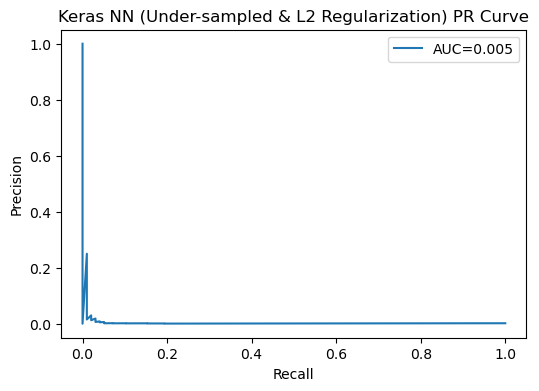

In [103]:
model_nn_us_l2 = make_nn(X_train_us)
es = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_nn_us_l2.keras', save_best_only=True)

# 4) Fit on the under‐sampled data, validate on your original VALID set
history_nn_us_l2 = model_nn_us.fit(
    X_train_us, y_train_us,
    validation_data=(X_valid_nn, y_valid_nn),
    epochs=40,
    batch_size=256,
    callbacks=[es, checkpoint],
    verbose=1
)

# 5) Evaluate on the untouched TEST set
y_prob_nn_us_l2  = model_nn_us_l2.predict(X_test_nn).ravel()
y_pred_nn_us_l2  = (y_prob_nn_us_l2 >= 0.5).astype(int)

print("Classification Report (Keras + undersampling):")
print(classification_report(y_test_nn, y_pred_nn_us_l2))

test_pr_nn_us_l2 = average_precision_score(y_test_nn, y_prob_nn_us_l2)
print(f"Test PR-AUC: {test_pr_nn_us_l2:.4f}")

plt.figure(figsize=(6,4))
prec, rec, _ = precision_recall_curve(y_test_nn, y_prob_nn_us_l2)
plt.plot(rec, prec, label=f"AUC={test_pr_nn_us_l2:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Keras NN (Under-sampled & L2 Regularization) PR Curve")
plt.legend()
plt.show()

The model overfits.

In [ ]:
joblib.dump(grid_log.best_estimator_, 'pipeline_logistic.pkl')
joblib.dump(grid_rf.best_estimator_,  'pipeline_rf.pkl')
joblib.dump(grid_xgb.best_estimator_, 'pipeline_xgb.pkl')

## Step 8: Conclusion

The final evaluation on the test data confirms the effectiveness of the models in detecting credit card fraud, particularly when using resampling techniques like RandomUnderSampler. Below are the key findings:

1. **Baseline Models (No Resampling):**
   - Logistic Regression models (L1 and L2) failed to generalize well, as indicated by their lack of test PR AUC scores.
   - Tree-based models (Random Forest and XGBoost) performed better during cross-validation but were not evaluated on the test set in this phase.

2. **Resampled Models (RandomUnderSampler and ADASYN):**
   - Both RandomUnderSampler and ADASYN significantly improved model performance during cross-validation, with near-perfect PR AUC scores.
   - On the test set, **Random Forest with RandomUnderSampler** achieved a **Test PR AUC of 0.8327**, while **XGBoost with RandomUnderSampler** achieved a slightly higher **Test PR AUC of 0.8358**.

3. **Optimal Thresholds:**
   - The optimal thresholds for classification were identified as **0.729** for Random Forest and **0.972** for XGBoost. These thresholds can be used to balance precision and recall based on business requirements.

### Final Recommendation:
- **Preferred Model:** **XGBoost with RandomUnderSampler** is the best-performing model on the test set, achieving the highest Test PR AUC score of **0.8358**.
- **Deployment Considerations:** Ensure threshold tuning is applied to optimize the trade-off between precision and recall for real-world deployment.
- **Monitoring:** Continuously monitor the model's performance in production to account for evolving fraud patterns and maintain high detection accuracy.